In [1]:
from src.u_mamba import U_Mamba

In [2]:
train_dir = 'dataset/training'
test_dir = 'dataset/test'

import os
from PIL import Image

def load_data_from_directory(directory):
    image_list = []
    mask_list = []
    image_folder = os.path.join(directory, 'images')
    mask_folder = os.path.join(directory, 'mask_veins')
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

    for img_filename, mask_filename in zip(image_filenames, mask_filenames):
        if img_filename.endswith(".tif") and mask_filename.endswith(".gif"):
            img = Image.open(os.path.join(image_folder, img_filename))
            mask = Image.open(os.path.join(mask_folder, mask_filename))
            image_list.append(img)
            mask_list.append(mask)

    return image_list, mask_list

train_images, train_masks = load_data_from_directory(train_dir)
# keep 5 images for test
test_images, test_masks = train_images[-5:], train_masks[-5:]
train_images, train_masks = train_images[:-5], train_masks[:-5]

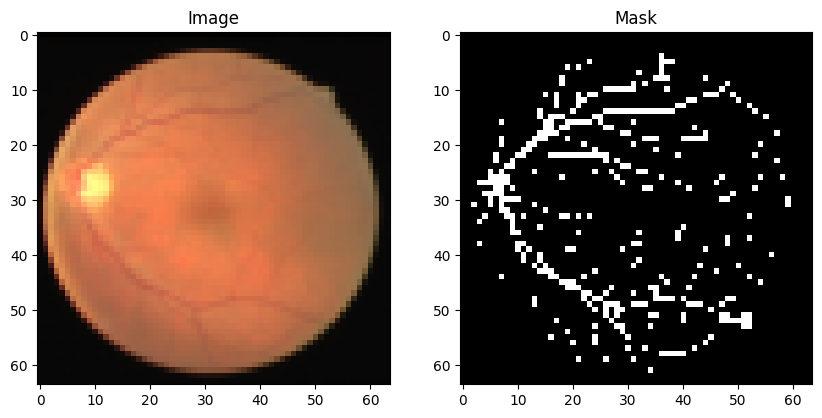

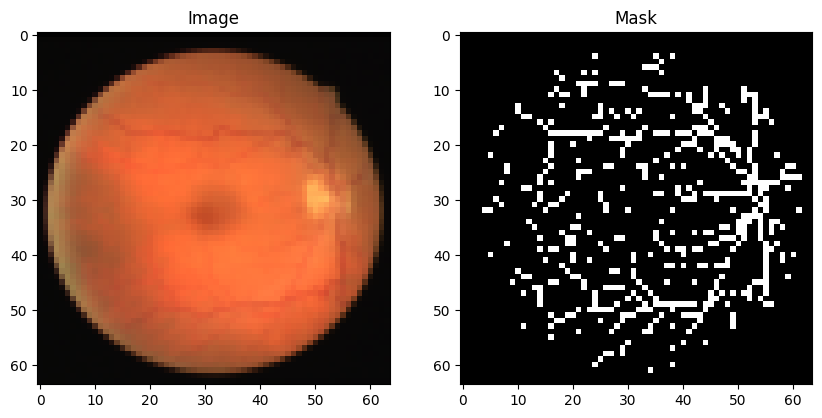

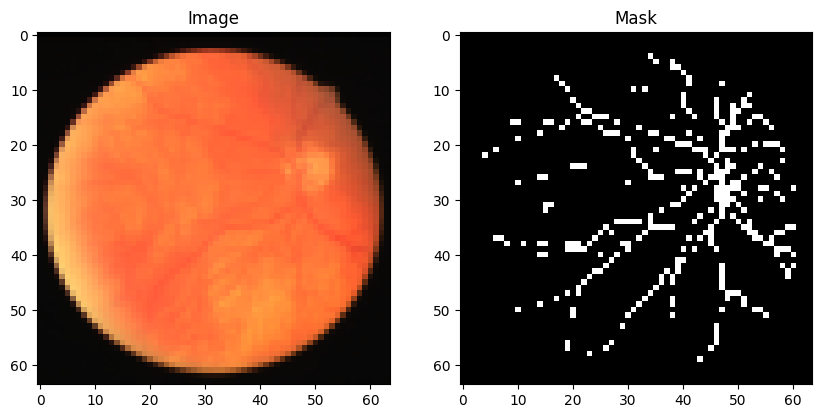

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess(images, masks):
    target_size = (64, 64)
    processed_images = []
    processed_masks = []

    for img, mask in zip(images, masks):

        mask_=np.array(mask)
        img_resized = img.resize(target_size, resample=Image.BILINEAR)
        mask_array = cv2.resize(mask_, target_size , interpolation=cv2.INTER_LINEAR)
        
        threshold_value = 70
        _,mask_array = cv2.threshold(mask_array, threshold_value, 255, cv2.THRESH_BINARY)
        img_array = np.array(img_resized)

        img_array = img_array.astype('uint8') 
        
        mask_array = mask_array.astype('uint8') 

        processed_images.append(img_array)
        processed_masks.append(mask_array)

    return processed_images, processed_masks

train_images_processed, train_masks_processed = preprocess(train_images,train_masks)
test_images_processed, test_masks_processed = preprocess(test_images,test_masks)

for i in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(train_images_processed[i], cmap='gray')
    ax[0].set_title('Image')
    
    ax[1].imshow(train_masks_processed[i], cmap='gray')
    ax[1].set_title('Mask')
    
    plt.show()

In [4]:
import numpy as np
from PIL import Image
import torch
import torchvision

train_images_array = np.array(train_images_processed)
train_masks_array = np.array(train_masks_processed)
train_masks_array = np.repeat(train_masks_array[:, :, :, np.newaxis], 3, axis=-1)

test_images_array = np.array(test_images_processed)
test_masks_array = np.array(test_masks_processed)
test_masks_array = np.repeat(test_masks_array[:, :, :, np.newaxis], 3, axis=-1)


def augment_data(images, masks):
    augmented_images = []
    augmented_masks = []

    # Define the transformations
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomRotation(15),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor()
    ])

    # Apply the transformations
    for img, msk in zip(images, masks):
        # Convert Numpy arrays to PIL Images
        pil_img = Image.fromarray(img)
        pil_msk = Image.fromarray(msk)

        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)  # Apply this seed to img transform

        trans_img = transform(pil_img)
        trans_msk = transform(pil_msk)
        augmented_images.append(trans_img)
        augmented_masks.append(trans_msk)

    return augmented_images, augmented_masks

train_images, train_masks = augment_data(train_images_array, train_masks_array)
test_images, test_masks = augment_data(test_images_array, test_masks_array)

# Convert lists of tensors to tensors
train_images = torch.stack(train_images)
train_masks = torch.stack(train_masks)

test_images = torch.stack(test_images)
test_masks = torch.stack(test_masks)


In [5]:
channels, width, height = 3, 64, 64
hidden_size = 4
rank = 3
state_size = 3
kernel_size = 3

model = U_Mamba(channels=channels, width=width, height=height, hidden_size=hidden_size, rank=rank, state_size=state_size, kernel_size=kernel_size, num_layers=2, target_classes=1)

In [ ]:
# set up training and validation data loaders

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

batch_size = 3
train_dataset = TensorDataset(train_images, train_masks)
test_dataset = TensorDataset(test_images, test_masks)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# set up the optimizer and the loss function
criterion = torch.nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


# train the model
epochs = 50
train_losses = []
test_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")

    train_loss = 0.0
    test_loss = 0.0

    for images, masks in tqdm(train_loader):
        images = images.to(device).unsqueeze(-1)
        masks = masks.to(device)
        masks = masks.type(torch.FloatTensor)

        optimizer.zero_grad()
        outputs = model(images)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        loss = criterion(outputs.sigmoid().squeeze(), masks)
        print(loss.item()) 
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() 

    with torch.no_grad():
        for images, masks in tqdm(test_loader):
            images = images.to(device).unsqueeze(-1)
            masks = masks.to(device)
            masks = masks.type(torch.FloatTensor)

            outputs = model(images)
            loss = criterion(outputs.sigmoid().squeeze(), masks)
            test_loss += loss.item() 

    train_loss = train_loss / len(train_loader)
    test_loss = test_loss / len(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print()